In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv
from arviz import hdi
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Traditional Model Evaluation

In [2]:
## Load diagnostic info.
diagnostics = read_csv(os.path.join('stan_results', 'X2.csv'))
diagnostics = diagnostics.set_index(['study','model'])

## Present diagnostic information.
diagnostics.round(3)

x2   df  rmsea    cfi    tli
study        model                                    
teicher2015  1      1857.519  702  0.040  0.927  0.923
             2      1372.694  663  0.032  0.955  0.950
             3      1570.836  692  0.035  0.944  0.940
             4      1253.093  687  0.028  0.964  0.961
tuominen2022 1      1086.115  702  0.031  0.954  0.952
             2       956.014  663  0.028  0.965  0.961
             3       881.108  692  0.022  0.977  0.976
             4       841.550  687  0.020  0.982  0.980

## Section 2: Posterior Predictive Model Checking

### 1.1 Observed score distribution

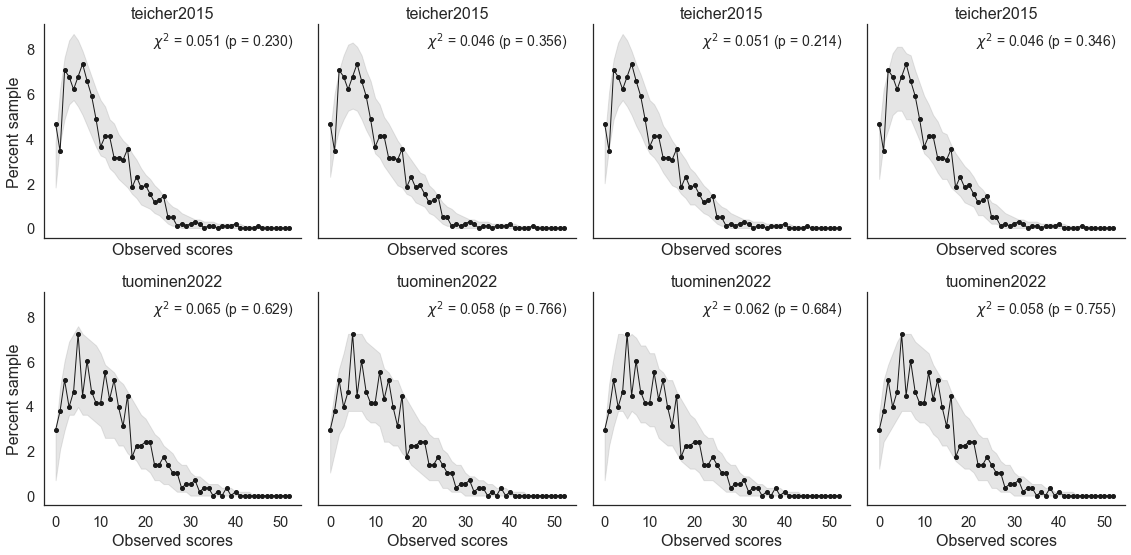

In [3]:
from arviz import hdi

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3,4]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
nrow = len(studies)
ncol = len(models)
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4,nrow*4), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

## Preallocate space.
ppmc = []

for j, m in enumerate(models):
    
    for i, study in enumerate(studies):

        ## Load posterior predictive check.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_nc.csv'), index_col=0)

        ## Normalize counts across samples.
        df.loc[:,:] /= df.loc[0].values.sum()

        ## Extract values.
        NC  = df.values[0]
        NCr = df.values[1:]
        ENC = NCr.mean(axis=0)

        ## Compute 95% HDI.
        lb, ub = np.apply_along_axis(hdi, 0, NCr, hdi_prob=0.95)

        ## Compute chi-square statistics.
        xi = np.sum(np.divide(np.square(NC - ENC), ENC, where=ENC > 0))
        xr = np.divide(np.square(NCr - ENC), ENC, where=ENC > 0).sum(axis=1)

        ## Compute ppp-value.
        pppv = (xi <= xr).mean()

        ## Store statistics.
        ppmc.append(dict(study=study, model=m, xi=xi, xr=xr.mean(), pval=pppv))
        
        ## Plot observed scores and 95% HDI.
        axes[i,j].plot(np.arange(NC.size), NC, 'o-', color='k', lw=1, markersize=4)    
        axes[i,j].fill_between(np.arange(NC.size), lb, ub, color='0.5', alpha=0.2)

        ## Add detail.
        axes[i,j].set(xticks=np.arange(0,51,10), xlabel='Observed scores', 
                      yticks=np.arange(0,0.09,0.02), yticklabels=np.arange(0,9,2),
                      ylabel='', title=study)
        if not j: axes[i,j].set_ylabel('Percent sample')

        ## Add annotations.
        axes[i,j].annotate(r'$\chi^2$ = %0.3f (p = %0.3f)' %(xi, pppv), (0,0), (0.97, 0.97), 
                           xycoords='axes fraction', ha='right', va='top', fontsize=14)
    
## Convert to DataFrame.
ppmc = DataFrame(ppmc).sort_values(['study', 'model']).set_index(['study','model'])
ppmc = ppmc.round(3)
    
sns.despine()
plt.tight_layout()

### 1.2 $Q_3$-index

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3,4]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

Q3 = read_csv('stan_results/Q3.csv')
    
for i, study in enumerate(studies):
        
    for j, m in enumerate(models):
        
        ## Restrict to study / model of interest.
        df = Q3.query(f'study == "{study}" and model == {m}')
        
        ## Print info.
        print('M%s: Q3 = %0.3f (%s)' %(m, df.Q3_99.max(), np.sum(df.Q3 > df.Q3_99.max())))

M1: Q3 = 0.239 (25)
M2: Q3 = 0.300 (10)
M3: Q3 = 0.255 (16)
M4: Q3 = 0.279 (8)
M1: Q3 = 0.250 (21)
M2: Q3 = 0.310 (4)
M3: Q3 = 0.316 (5)
M4: Q3 = 0.318 (1)


## Section 2: Model Comparison

In [5]:
from itertools import combinations

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3,4]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
loocv = []

for study in studies:

    for m in models:
        
        ## Load data.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc.csv'))
        
        ## Compute LOO-CV.
        loo = -2 * df.loo.sum()
        
        ## Append.
        loocv.append(dict(study=study, model=m, loo=loo))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).sort_values(['study', 'model']).set_index(['study','model']).round(1)

## Iteratively add comparison.
loocv['delta'] = '-'
for study in studies:
    
    ## Load winning model.
    x = read_csv(os.path.join('stan_results', study, f'grmq_m4_ppmc.csv'))
    
    for m in [1,2,3]:
        
        ## Load alternate model.
        y = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc.csv'))
        
        ## Compute delta-LOO.
        arr = (-2*x.loo) - (-2*y.loo)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(len(x))
        
        ## Store.
        loocv.loc[(study,m),'delta'] = '%0.1f (%0.1f)' %(mu, se)
    
## Display DataFrame.
loocv

loo           delta
study        model                         
teicher2015  1      30967.2  -1748.0 (76.7)
             2      29211.3      7.9 (56.3)
             3      30531.1  -1312.0 (68.0)
             4      29219.2               -
tuominen2022 1      19771.6  -1089.3 (58.4)
             2      18706.2    -24.0 (52.0)
             3      19177.7   -495.5 (45.0)
             4      18682.2               -

## Section 3: Tables & Figures

### 3.1 Table 1

In [ ]:
## Merge DataFrames.
table = ppmc1.merge(ppmc2, left_index=True, right_index=True)
table = table.merge(ppmc0, left_index=True, right_index=True)

## Display DataFrame.
table

In [ ]:
## Convert to Latex.
print(table.to_latex())

### 3.2 Figure S3

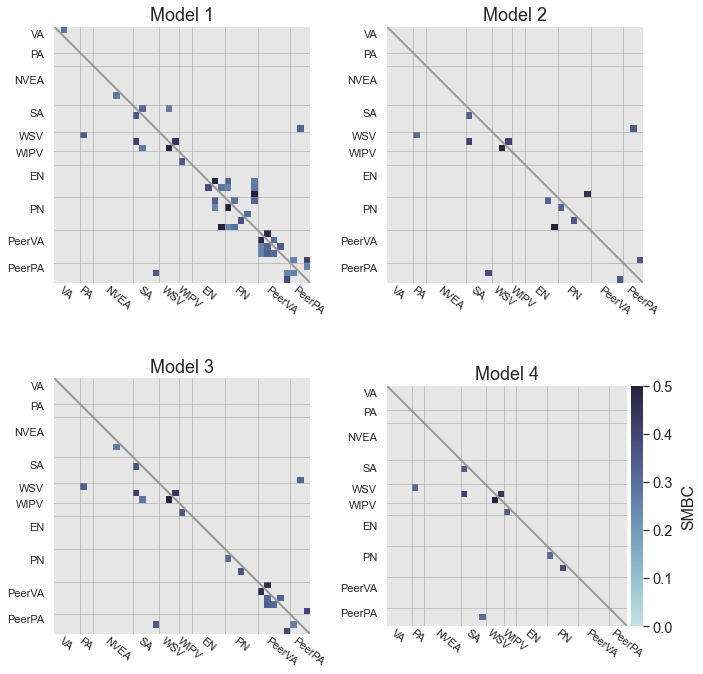

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3,4]

## Define threshold.
thresh = 0.99

## Define labels.
titles = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

## Define color palette.
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

## Define item order.
order = dict(
    VA = [0, 1, 2, 3], 
    PA = [5, 6], 
    NVEA = [4, 26, 27, 34, 35, 36], 
    SA = [7, 8, 12, 23], 
    WSV = [9, 10, 11], 
    WIPV = [13, 14], 
    EN = [24, 25, 28, 29, 38], 
    PN = [30, 31, 32, 33, 37], 
    PeerVA = [15, 16, 17, 18, 19], 
    PeerPA = [20, 21, 22]
)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

## Define tick positions.
lengths = [len(v) for v in order.values()]
ticks = [j/2 + np.sum(lengths[:i]) - 1.5 for i, j in enumerate(lengths)]

## Main loop.
ix = np.concatenate(list(order.values()))
for j, (ax, m) in enumerate(zip(axes.flatten(), models)):
    
    ## Construct SMBC matrix. 
    smbc = np.zeros((ix.max()+1, ix.max()+1))
    for i, study in enumerate(studies):  
        
        ## Preallocate space.
        tmp = np.zeros_like(smbc)
        
        ## Load posterior predictive model check.
        df = Q3.query(f'study == "{study}" and model == {m}')
        
        ## Populate matrix.
        tmp[df.k1, df.k2] = tmp[df.k2, df.k1] = np.where(df.Q3 > df.Q3_99.max(), df.Q3, 0)
        
        ## Reorganize rows / columns.
        tmp = tmp[ix][:,ix]
        
        ## Store.
        if i: smbc += np.triu(tmp)
        else: smbc += np.tril(tmp)
            
    ## Handle colorbar.
    if m == models[-1]:
        cbar = True
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    else: 
        cbar = False
        cbar_ax = None
            
    ## Plot background tiles. 
    sns.heatmap(np.identity(len(smbc)), cmap=ListedColormap(['0.9','0.9']), 
                square=True, cbar=False, ax=ax)
            
    ## Plot SMBC.
    sns.heatmap(smbc, cmap=cmap, vmin=0.0, vmax=0.5, cbar=cbar, mask=smbc==0, square=True,
                xticklabels=[], yticklabels=[], ax=ax, cbar_ax=cbar_ax)
    
    ## Draw boundary lines.
    ax.plot([0,40], [0,40], color='0.6', lw=2)
    for k in np.cumsum([len(v) for v in order.values()]): 
        ax.axhline(k, color='0.6', lw=0.5)
        ax.axvline(k, color='0.6', lw=0.5)
        
    ## Add details.
    ax.set(xticks=ticks, yticks=ticks)
    ax.set_xticklabels(order.keys(), ha='left', fontsize=11, rotation=-40)
    ax.set_yticklabels(order.keys(), va='top', fontsize=11, rotation=0)
    ax.tick_params(axis='x', which='major', pad=-5)
    ax.set_title(titles[j], fontsize=18)
    
    ## Update colorbar.
    if cbar:
        cbar = ax.collections[1].colorbar
        cbar.set_label(r'SMBC', labelpad=8)
        
plt.tight_layout()
# plt.savefig(os.path.join('..', 'figures', 'fig01.png'), dpi=100)